<a href="https://colab.research.google.com/github/haoboooo/Temporal-Generalization-of-Sentiment-Analysis-on-Amazon-Reviews/blob/main/video_games/game_finetune_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install emot

     |████████████████████████████████| 61 kB 22 kB/s 


In [ ]:
import pandas as pd
import numpy as np
import string
import os

# text preprocessing
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
from emot.emo_unicode import EMOTICONS_EMO, UNICODE_EMOJI

# plots and metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model

from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,Dropout,Masking,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential,load_model

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.test.is_built_with_cuda())
print(tf.keras.__version__)
print(tf.__version__)

Default GPU Device: /device:GPU:0
True
2.8.0
2.8.0


In [ ]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## load game data

In [ ]:
file1 = "./drive/MyDrive/Colab Notebooks/CL/game/97_06.csv"
file2 = "./drive/MyDrive/Colab Notebooks/CL/game/07_12.csv"
file3 = "./drive/MyDrive/Colab Notebooks/CL/game/13_17.csv"
file4 = "./drive/MyDrive/Colab Notebooks/CL/game/18.csv"

In [ ]:
def load_data(file):
  # read csv data and set columns
  df = pd.read_csv(file,usecols=['overall', 'reviewTime','reviewText'])

  # remove the duplicates if any
  df.duplicated('reviewText').sum()
  df.drop_duplicates(subset=['reviewText'],inplace=True)
  
  # remove NaN rows
  df.isnull().sum()
  df.dropna(how='any',axis=0,inplace=True)
  shape = df.shape
  counts = df.overall.value_counts()# labels count

  sns.countplot(df['overall']) # plot bar graph
  fig = plt.gcf() # get current figure
  fig.set_size_inches(5,5) # set the figure size
  plt.title('overall') # add title to the figure

  return df,shape,counts

(95385, 3)
 1.0    69406
-1.0    18035
 0.0     7944
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2006,This game is a good time. Especially if you h...
1,0.0,2005,Don't expect the bells and whistles that you f...
2,1.0,2005,"It is fun to play this game, I really like it...."
3,1.0,2006,Here's the deal with this item: it's fine for ...
4,0.0,2006,We bought this for Christmas for our three kid...


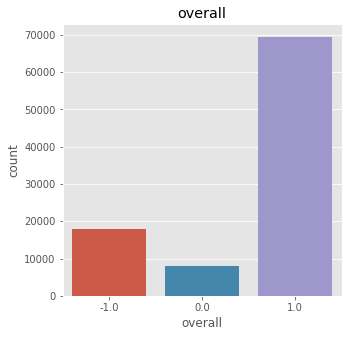

In [ ]:
# load data for 1997 - 2006
df1,shape1,counts1 = load_data(file1)
print(shape1)
print(counts1)
df1.head()

(273501, 3)
 1.0    193149
-1.0     55507
 0.0     24845
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2012,I oredered this for a daughter who is now 33 a...
1,1.0,2010,Well I thought since this idem didn't have any...
2,1.0,2012,Good game. Good graphics. A bit of a learning ...
3,-1.0,2012,"If you buy this game, you will regret it. If ..."
4,1.0,2012,4 Stars because they like it and play it often...


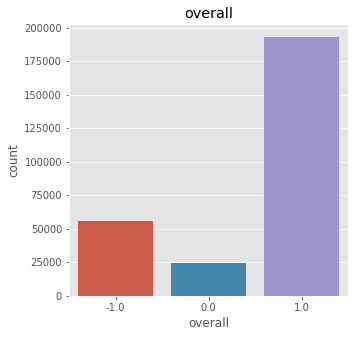

In [ ]:
# load data for 2007 - 2012
df2,shape2,counts2 = load_data(file2)
print(shape2)
print(counts2)
df2.head()

(957163, 3)
 1.0    672584
-1.0    210099
 0.0     74480
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,-1.0,2014,I used to play this game years ago and loved i...
1,0.0,2014,The game itself worked great but the story lin...
2,1.0,2014,I had to learn the hard way after ordering thi...
3,-1.0,2014,The product description should state this clea...
4,1.0,2014,I would recommend this learning game for anyon...


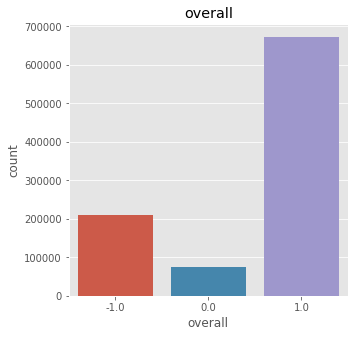

In [ ]:
# load data for 2013 - 2017
df3,shape3,counts3 = load_data(file3)
print(shape3)
print(counts3)
df3.head()

(80396, 3)
 1.0    52744
-1.0    21618
 0.0     6034
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,overall,reviewTime,reviewText
0,1.0,2018,No complaints! Sing your little heart out!
1,1.0,2018,Works great with Xbox 360. I have 2 of these u...
2,1.0,2018,The game was perfect and super clean. Very ple...
3,1.0,2018,It was perfect gift. Got it for Christmas and ...
4,1.0,2018,Lik3d it


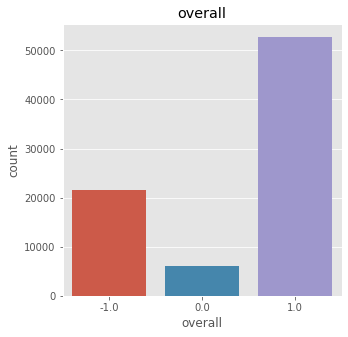

In [ ]:
# load data for 2018
df4,shape4,counts4 = load_data(file4)
print(shape4)
print(counts4)
df4.head()

## Split and Balance train&test

Balance each time period for 
5000 positive，5000 negative，5000 neutral

80%(12000) training and 20%(3000) testing

In [ ]:
def split_balance(df):
  # get data of each class
  groups = df.groupby(df.overall)
  pos = groups.get_group(1)
  neu = groups.get_group(0)
  neg = groups.get_group(-1)

  # shuffle the dataframe
  pos = pos.sample(frac=1.0)
  neu = neu.sample(frac=1.0)
  neg = neg.sample(frac=1.0)

  # split to get train for each class
  train_posdata = pos.iloc[:4000,:]
  train_neudata = neu.iloc[:4000,:]
  train_negdata = neg.iloc[:4000,:]

  # split to get test for each class
  test_posdata = pos.iloc[4000:5000,:]
  test_neudata = neu.iloc[4000:5000,:]
  test_negdata = neg.iloc[4000:5000,:]

  train = pd.concat([train_posdata, train_neudata, train_negdata],sort=False).sample(frac=1.0)
  test = pd.concat([test_posdata, test_neudata, test_negdata],sort=False).sample(frac=1.0)

  return train,test

In [ ]:
# data for 1997 - 2006
df1_train,df1_test = split_balance(df1)

# data for 2007 - 2012
df2_train,df2_test = split_balance(df2)

# data for 2013 - 2017
df3_train,df3_test = split_balance(df3)

# data for 2018
df4_train,df4_test = split_balance(df4)

In [ ]:
df1_train["overall"] = df1_train["overall"].replace(-1,2)
df1_test["overall"] = df1_test["overall"].replace(-1,2)

df2_train["overall"] = df2_train["overall"].replace(-1,2)
df2_test["overall"] = df2_test["overall"].replace(-1,2)

df3_train["overall"] = df3_train["overall"].replace(-1,2)
df3_test["overall"] = df3_test["overall"].replace(-1,2)

df4_train["overall"] = df4_train["overall"].replace(-1,2)
df4_test["overall"] = df4_test["overall"].replace(-1,2)

In [ ]:
df1_test.shape

(3000, 3)

## Text Preprocessing

In [ ]:
# get stopwords from txt
def get_stop_words(txt):
    #read the stop words
    with open(txt,'r') as f:
        stopwords_list=f.readlines()
    for i in range (0,len(stopwords_list)):
        stopwords_list[i]=stopwords_list[i].replace('\n','')
    return stopwords_list

In [ ]:
# Defining my NLTK stop words and my user-defined stop words
stop_words = list(stopwords.words('english'))
alphabets = list(string.ascii_lowercase) # 26 letters with lowercase
user_stop_words = get_stop_words("./drive/MyDrive/Colab Notebooks/CL/stopwords.txt")
stop_words = stop_words+alphabets+user_stop_words
emojis = {**UNICODE_EMOJI,**EMOTICONS_EMO} # full list of emojis unicodes

In [ ]:
def processtext(txt):
  # replace all emojis
  for emo in emojis.keys():
    txt = txt.replace(emo,"EMOJI "+emojis[emo])
  
  txt = txt.replace('\r', '').replace('\n', ' ')
  # remove all html tag
  txt = re.sub("(<.*?>)", "", txt)
  # remove all urls
  txt = re.sub('https?:\/\/\S+','',txt)
  # remove @ references  
  txt = re.sub('@[\w_]+','',txt)
  # remove # hashtags
  txt = re.sub('#\S+','',txt)
  # replace digits with no space
  txt = re.sub(r"\d", '',txt)
  # convert tweet to lower case
  txt = txt.lower()
  # remove all multiple white spaces
  txt = re.sub('[\s]+',' ',txt)
  # remove all punctuations and non-ascii
  txt = re.sub('[\.?!,;:\-\[\]\{\}\(\)\'\"/]','',txt)
  txt = txt.replace('$','').replace('&','')
  # remove whitespace
  txt = txt.strip()

  tokens = word_tokenize(txt)
  filtered_words = [w for w in tokens if w not in stop_words]
  # filtered_words = [w for w in filtered_words if w in word_list]
  return " ".join(filtered_words)

In [ ]:
df1_train["cleanText"] = df1_train["reviewText"].apply(processtext)
df1_test["cleanText"] = df1_test["reviewText"].apply(processtext)

df2_train["cleanText"] = df2_train["reviewText"].apply(processtext)
df2_test["cleanText"] = df2_test["reviewText"].apply(processtext)

df3_train["cleanText"] = df3_train["reviewText"].apply(processtext)
df3_test["cleanText"] = df3_test["reviewText"].apply(processtext)

df4_train["cleanText"] = df4_train["reviewText"].apply(processtext)
df4_test["cleanText"] = df4_test["reviewText"].apply(processtext)

In [ ]:
df1_train.head()

,overall,reviewTime,reviewText,cleanText
69278,1.0,2005,this is an excellent ww2 game-it is difficult ...,excellent ww gameit difficult challengingthe s...
12282,1.0,2000,If you are like me and you love RTS games but ...,like love rts games hate building researching ...
15347,1.0,2006,I bought it after I saw it on a tv commercial....,bought saw tv commercial thought looked awesom...
25633,1.0,2003,I bought the Wavebrid wireless controller beca...,bought wavebrid wireless controller gamecube c...
67093,2.0,2005,I have been playing history related rts's for ...,playing history related rtss quite time starti...


## Text Tokenization

In [ ]:
def tokenize(data1,data2):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data1)
  print(f"{len(tokenizer.word_index)} words are used")

  vocab_size=len(tokenizer.word_index)
  tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(data1)
  train_fea = tokenizer.texts_to_sequences(data1)
  test_fea = tokenizer.texts_to_sequences(data2)

  length_tr = [len(s) for s in train_fea]
  print("Training:")
  print(f"Average length of each row >> {np.mean(length_tr)}")
  print(f"Maximum length of each row >> {np.max(length_tr)}")
  plt.hist(length_tr,bins=50)
  plt.show()

  length_te = [len(s) for s in test_fea]
  print("Testing")
  print(f"Average length of each row >> {np.mean(length_te)}")
  print(f"Maximum length of each row >> {np.max(length_te)}")
  plt.hist(length_te,bins=50)
  plt.show()

  seq_len = max(max(length_tr),max(length_te))
  print("max sequence length: ",seq_len)

  return train_fea,test_fea,vocab_size,seq_len

48392 words are used
Training:
Average length of each row >> 77.15633333333334
Maximum length of each row >> 2381


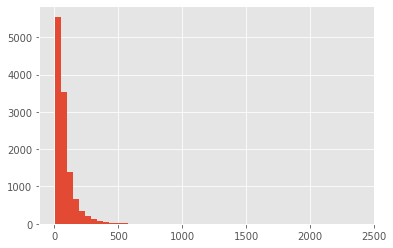

Testing
Average length of each row >> 75.20866666666667
Maximum length of each row >> 1344


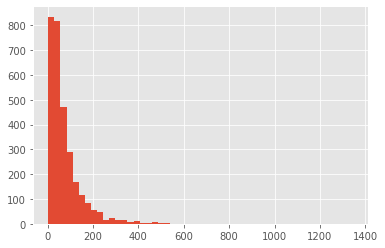

max sequence length:  2381


In [ ]:
df1_train_fea,df1_test_fea,df1_vocab_size,df1_maxlen = tokenize(df1_train["cleanText"],df1_test["cleanText"])

35106 words are used
Training:
Average length of each row >> 58.645833333333336
Maximum length of each row >> 2992


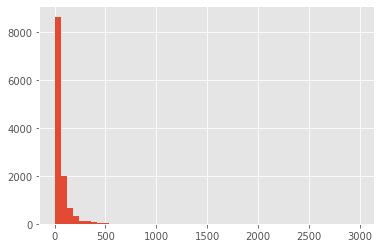

Testing
Average length of each row >> 53.325
Maximum length of each row >> 994


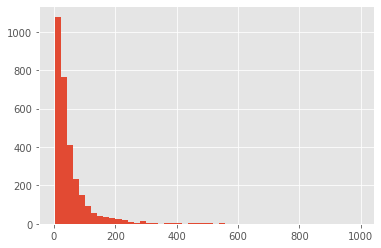

max sequence length:  2992


In [ ]:
df2_train_fea,df2_test_fea,df2_vocab_size,df2_maxlen = tokenize(df2_train["cleanText"],df2_test["cleanText"])

20189 words are used
Training:
Average length of each row >> 26.871666666666666
Maximum length of each row >> 2795


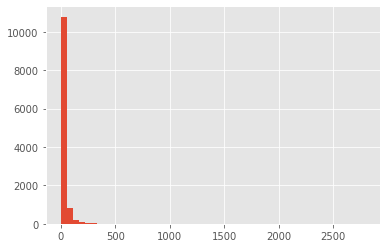

Testing
Average length of each row >> 24.760666666666665
Maximum length of each row >> 712


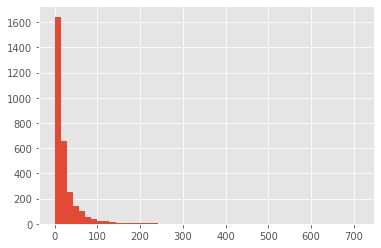

max sequence length:  2795


In [ ]:
df3_train_fea,df3_test_fea,df3_vocab_size,df3_maxlen = tokenize(df3_train["cleanText"],df3_test["cleanText"])

14348 words are used
Training:
Average length of each row >> 19.092583333333334
Maximum length of each row >> 595


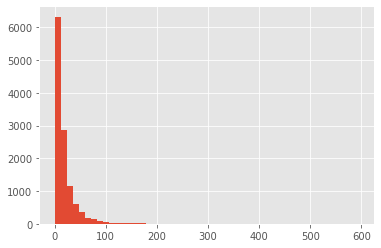

Testing
Average length of each row >> 18.655666666666665
Maximum length of each row >> 382


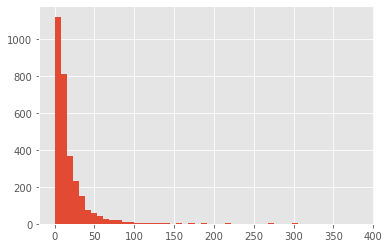

max sequence length:  595


In [ ]:
df4_train_fea,df4_test_fea,df4_vocab_size,df4_maxlen = tokenize(df4_train["cleanText"],df4_test["cleanText"])

## Padding

In [ ]:
sequence_size = 400
print("max sequence length for game: ",sequence_size)

max sequence length for game:  400


In [ ]:
df1_train_pad = pad_sequences(df1_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_test_pad = pad_sequences(df1_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df1_train_label = to_categorical(df1_train.overall,num_classes=3)
df1_test_label = to_categorical(df1_test.overall,num_classes=3)

df2_train_pad = pad_sequences(df2_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_test_pad = pad_sequences(df2_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df2_train_label = to_categorical(df2_train.overall,num_classes=3)
df2_test_label = to_categorical(df2_test.overall,num_classes=3)

df3_train_pad = pad_sequences(df3_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_test_pad = pad_sequences(df3_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df3_train_label = to_categorical(df3_train.overall,num_classes=3)
df3_test_label = to_categorical(df3_test.overall,num_classes=3)

df4_train_pad = pad_sequences(df4_train_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_test_pad = pad_sequences(df4_test_fea,maxlen=sequence_size,padding='post',truncating='post')
df4_train_label = to_categorical(df4_train.overall,num_classes=3)
df4_test_label = to_categorical(df4_test.overall,num_classes=3)

## Build LSTM Model and Train on 1997-2006

In [ ]:
# hyperparameters
word_vec_size = 100
hidden_size = 128
batch_size = 256
epochs = 8
vocab_size = max(df1_vocab_size,df2_vocab_size,df3_vocab_size,df4_vocab_size)
print("max vocab size: ",vocab_size)

max vocab size:  48392


In [ ]:
def bilstm_model():
    model = Sequential()
    model.add(Input(shape=[sequence_size]))
    model.add(Embedding(vocab_size,word_vec_size,input_length=sequence_size))
    model.add(Bidirectional(LSTM(hidden_size,return_sequences=True)))
    model.add(Flatten())
    model.output_shape
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model
es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)

In [ ]:
lstm = bilstm_model()
plot_model(lstm)
lstm_no_hist = lstm.fit(df1_train_pad,df1_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df1_test_pad,df1_test_label),callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          4839200   
                                                                 
 bidirectional (Bidirectiona  (None, 400, 256)         234496    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 102400)            0         
                                                                 
 dense (Dense)               (None, 32)                3276832   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                        

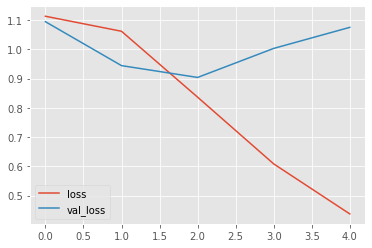

In [ ]:
plt.plot(lstm_no_hist.history['loss'], label='loss')
plt.plot(lstm_no_hist.history['val_loss'], label = 'val_loss')
plt.legend()

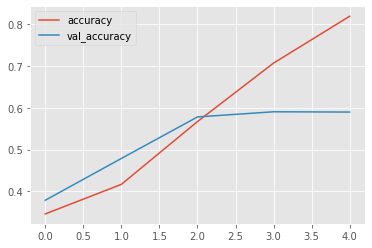

In [ ]:
plt.plot(lstm_no_hist.history['accuracy'], label= 'accuracy')
plt.plot(lstm_no_hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
lstm.save('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM.h5')

## Evaluate on other data

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM.h5')
load_lstm.evaluate(df2_test_pad,df2_test_label)

94/94 [==============================] - 2s 17ms/step - loss: 1.7873 - accuracy: 0.3267


[1.7872657775878906, 0.3266666531562805]

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM.h5')
load_lstm.evaluate(df3_test_pad,df3_test_label)

94/94 [==============================] - 3s 17ms/step - loss: 1.5196 - accuracy: 0.3173


[1.5196083784103394, 0.3173333406448364]

In [ ]:
load_lstm = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM.h5')
load_lstm.evaluate(df4_test_pad,df4_test_label)

94/94 [==============================] - 2s 17ms/step - loss: 1.4401 - accuracy: 0.3347


[1.4401353597640991, 0.3346666693687439]

## Fine tuned on 2007-2012 data

In [ ]:
plot_model(load_lstm)
lstm_no_hist = load_lstm.fit(df2_train_pad,df2_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df2_test_pad,df2_test_label),callbacks=[es])

Epoch 1/8
47/47 [==============================] - 8s 102ms/step - loss: 1.1396 - accuracy: 0.3344 - val_loss: 1.0987 - val_accuracy: 0.3330
Epoch 2/8
47/47 [==============================] - 5s 102ms/step - loss: 1.0964 - accuracy: 0.3454 - val_loss: 1.0959 - val_accuracy: 0.3583
Epoch 3/8
47/47 [==============================] - 5s 99ms/step - loss: 1.0936 - accuracy: 0.3549 - val_loss: 1.0950 - val_accuracy: 0.3590
Epoch 4/8
47/47 [==============================] - 5s 98ms/step - loss: 1.0800 - accuracy: 0.3958 - val_loss: 1.0940 - val_accuracy: 0.3990
Epoch 5/8
47/47 [==============================] - 5s 98ms/step - loss: 1.0363 - accuracy: 0.4501 - val_loss: 1.0567 - val_accuracy: 0.4840
Epoch 5: early stopping


In [ ]:
load_lstm.save('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_2.h5')

## Evaluate on other data

In [ ]:
load_lstm_ft_2 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_2.h5')
load_lstm_ft_2.evaluate(df1_test_pad,df1_test_label)

94/94 [==============================] - 3s 17ms/step - loss: 1.0142 - accuracy: 0.5463


[1.014169692993164, 0.5463333129882812]

In [ ]:
load_lstm_ft_2 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_2.h5')
load_lstm_ft_2.evaluate(df3_test_pad,df3_test_label)

94/94 [==============================] - 3s 17ms/step - loss: 1.1336 - accuracy: 0.3660


[1.133640170097351, 0.3659999966621399]

In [ ]:
load_lstm_ft_2 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_2.h5')
load_lstm_ft_2.evaluate(df4_test_pad,df4_test_label)

94/94 [==============================] - 3s 16ms/step - loss: 1.1208 - accuracy: 0.3707


[1.1208136081695557, 0.37066665291786194]

## Fine tuned on 2013-2017

In [ ]:
load_lstm_ft_2 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_2.h5')

In [ ]:
plot_model(load_lstm_ft_2)
lstm_no_hist = load_lstm_ft_2.fit(df3_train_pad,df3_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df3_test_pad,df3_test_label),callbacks=[es])

Epoch 1/8
47/47 [==============================] - 8s 126ms/step - loss: 1.1003 - accuracy: 0.3517 - val_loss: 1.0885 - val_accuracy: 0.3907
Epoch 2/8
47/47 [==============================] - 5s 98ms/step - loss: 1.0628 - accuracy: 0.4209 - val_loss: 0.9730 - val_accuracy: 0.5343
Epoch 3/8
47/47 [==============================] - 5s 98ms/step - loss: 0.8925 - accuracy: 0.5235 - val_loss: 0.8332 - val_accuracy: 0.5890
Epoch 4/8
47/47 [==============================] - 5s 98ms/step - loss: 0.7314 - accuracy: 0.6506 - val_loss: 0.8352 - val_accuracy: 0.6173
Epoch 5/8
47/47 [==============================] - 5s 99ms/step - loss: 0.5846 - accuracy: 0.7458 - val_loss: 0.8739 - val_accuracy: 0.6320
Epoch 5: early stopping


In [ ]:
load_lstm_ft_2.save('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_3.h5')

## Evaluate on other data

In [ ]:
load_lstm_ft_3 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_3.h5')
load_lstm_ft_3.evaluate(df1_test_pad,df1_test_label)

94/94 [==============================] - 2s 17ms/step - loss: 1.9743 - accuracy: 0.3943


[1.9743199348449707, 0.3943333327770233]

In [ ]:
load_lstm_ft_3 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_3.h5')
load_lstm_ft_3.evaluate(df2_test_pad,df2_test_label)

94/94 [==============================] - 2s 17ms/step - loss: 1.8567 - accuracy: 0.3800


[1.856687307357788, 0.3799999952316284]

In [ ]:
load_lstm_ft_3 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_3.h5')
load_lstm_ft_3.evaluate(df4_test_pad,df4_test_label)

94/94 [==============================] - 3s 16ms/step - loss: 1.6574 - accuracy: 0.3490


[1.6573915481567383, 0.3490000069141388]

## Fine tuned on 2018

In [ ]:
load_lstm_ft_3 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_3.h5')

In [ ]:
plot_model(load_lstm_ft_3)
lstm_no_hist = load_lstm_ft_3.fit(df4_train_pad,df4_train_label,epochs=epochs,batch_size=batch_size,validation_data=(df4_test_pad,df4_test_label),callbacks=[es])

Epoch 1/8
47/47 [==============================] - 9s 126ms/step - loss: 1.1119 - accuracy: 0.3895 - val_loss: 1.0643 - val_accuracy: 0.4380
Epoch 2/8
47/47 [==============================] - 5s 100ms/step - loss: 1.0261 - accuracy: 0.4681 - val_loss: 0.9200 - val_accuracy: 0.5543
Epoch 3/8
47/47 [==============================] - 5s 99ms/step - loss: 0.8446 - accuracy: 0.5861 - val_loss: 0.8079 - val_accuracy: 0.6083
Epoch 4/8
47/47 [==============================] - 5s 101ms/step - loss: 0.6581 - accuracy: 0.7095 - val_loss: 0.7847 - val_accuracy: 0.6563
Epoch 5/8
47/47 [==============================] - 5s 100ms/step - loss: 0.5172 - accuracy: 0.7891 - val_loss: 0.8447 - val_accuracy: 0.6613
Epoch 5: early stopping


In [ ]:
load_lstm_ft_3.save('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_4.h5')

## Evaluate on other data

In [ ]:
load_lstm_ft_4 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_4.h5')
load_lstm_ft_4.evaluate(df1_test_pad,df1_test_label)

94/94 [==============================] - 2s 17ms/step - loss: 2.4098 - accuracy: 0.3443


[2.4097790718078613, 0.34433332085609436]

In [ ]:
load_lstm_ft_4 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_4.h5')
load_lstm_ft_4.evaluate(df2_test_pad,df2_test_label)

94/94 [==============================] - 2s 17ms/step - loss: 2.2222 - accuracy: 0.3540


[2.2221670150756836, 0.3540000021457672]

In [ ]:
load_lstm_ft_4 = load_model('./drive/MyDrive/Colab Notebooks/CL/game/LSTM/BiLSTM_fine_tuned_4.h5')
load_lstm_ft_4.evaluate(df3_test_pad,df3_test_label)

94/94 [==============================] - 2s 16ms/step - loss: 1.7074 - accuracy: 0.4177


[1.7073932886123657, 0.4176666736602783]